In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.plot import plot_cost_to_go, plot_rewards, plot_loss_hist
from deep_rl.mountaincar.policy_gradient import PolicyModel, ValueModel
from deep_rl.algorithms import play_pg_one_td, play_episode
from deep_rl.utils import FeatureTransformer
import gymnasium as gym
import numpy as np
import plotly.io as pio
from tqdm import tqdm
import pandas as pd
import plotly.express as px

pio.renderers.default = "jupyterlab"

In [3]:
env = gym.make('MountainCar-v0')
ft = FeatureTransformer(env, n_components=100)
dim = ft.dimensions
pmodel = PolicyModel(dim, env.action_space.n, ft, epsilon=0.1)
vmodel = ValueModel(dim, ft)

In [4]:
gamma = 0.95
it_episodes = 1000
N = 100
totalrewards = np.empty(N)
costs = np.empty(N)
losses = []

for n in tqdm(range(N), position=0):
  rewards, loss = play_pg_one_td(env, pmodel, vmodel, gamma, it_episodes, verbose=False, pbar_prefix=f'Episode={n+1}')
  totalrewards[n] = np.sum(rewards)
  losses.append(loss)

plot_rewards(totalrewards, rolling_period=100)
plot_rewards(totalrewards)
plot_cost_to_go(env, vmodel)
plot_loss_hist(losses)

100%|██████████| 100/100 [39:58<00:00, 23.98s/it]


Running episode:  53%|█████▎    | 160/300 [00:13<00:12, 11.57it/s]


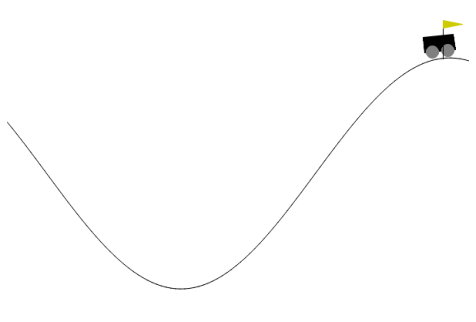

In [5]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
policy = lambda x: pmodel.sample_action(x)
play_episode(env, policy, max_iter=300, save_animation=True)

In [6]:
def mountain_car_hist(hist):
    cols = ['position', 'velocity', 'reward', 'action']
    hist_df = (pd.DataFrame(np.hstack([hist['observations'],
                             hist['rewards'].reshape((-1, 1)),
                             hist['actions'].reshape((-1, 1))]),
                            columns=cols)
               .assign(action=lambda df: df.action.map({0: 'left', 1: 'nothing', 2: 'right'})))
    return hist_df

In [7]:
env = gym.make('MountainCar-v0')
policy = lambda x: pmodel.sample_action(x, greedy=True)
hist = []
for _ in tqdm(range(30), desc='Episode', position=0):
    hist.append(mountain_car_hist(play_episode(env, policy, verbose=False, return_hist=True)))

Episode: 100%|██████████| 30/30 [02:54<00:00,  5.81s/it]


In [8]:
np.mean([len(h) for h in hist])

127.43333333333334

In [9]:
from plotly.graph_objs import Figure

color_map = {k: px.colors.qualitative.D3[i] for i, k in enumerate(['left', 'nothing', 'right'])}
fig = Figure()
for h in hist:
    fig.add_scatter(x=h['position'],
                    y=h['velocity'],
                    mode='lines+markers',
                    name=h['reward'].sum(),
                    # showlegend=False,
                    # marker=dict(color=h['action'].map(color_map), size=4),
                    marker=dict(size=4),
                    # line=dict(width=1, color='lightgray'),
                    line=dict(width=1),
                    )

fig.update_layout(template='plotly_white')
fig.show()

In [10]:
num_grid = 30  # Number of points per dimension in the grid
position = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num_grid)
velocity = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num_grid)

grid = np.dstack(np.meshgrid(position, velocity)).reshape(-1, 2)
actions = np.array([policy(x) for x in tqdm(grid, position=0)])
grid_df = (pd.DataFrame(np.hstack([grid, actions.reshape((-1, 1))]),
                       columns=['position', 'velocity', 'action'])
           .assign(action=lambda df: df.action.map({0: 'left', 1: 'nothing', 2: 'right'})))
grid_df.head()

100%|██████████| 900/900 [00:42<00:00, 20.93it/s]


,position,velocity,action
0,-1.200000,-0.07,left
1,-1.137931,-0.07,left
2,-1.075862,-0.07,left
3,-1.013793,-0.07,left
4,-0.951724,-0.07,left


In [11]:
px.scatter(grid_df, x='position',  y='velocity', color='action', template='plotly_white')